## **Calculating the surface-forced water mass transformation in potential density coordinates**

### **Description**

This recipe shows how to calculate the surface-forced water mass transformation in potential density-coordinates using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using JRA55-do from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

---
### **Background:**
The surface-forced diapycnal water mass transformation is used to quantify the volume flux across isopycnal outcrops due to surface buoyancy fluxes and can be defined at time $t$ as follows:

First, we computing the surface density flux due to the fluxes of heat $Q_H$ (W m-2) and freshwater $Q_{FW}$ (kg m-2 s-1) at the sea surface following
Speer and Tziperman (1992):

$$f(\lambda, \phi, t) = -\frac{\alpha}{c_{p}} Q_{H}(\lambda, \phi, t) + \beta \frac{S(\lambda, \phi, t)}{1 - S(\lambda, \phi, t)} Q_{FW}(\lambda, \phi, t)$$

where $\alpha$ is the thermal expansion coefficient, $\beta$ is the haline contraction coefficient, $c_p$ is the specific heat capacity of seawater and $S$ is the sea surface salinity. Notably, a positive surface density flux (i.e., $f(\lambda, \phi, t)$ > 0 kg m−2 s−1) represents an increase in sea surface density.

We then calculate the surface-forced diapycnal water mass transformation $H(\sigma^{*}, t)$ across an outcropping isopycnal surface by integrating the surface density flux over the area of each surface density outcrop $\sigma^{*}$:

$$H(\sigma^{*}, t) = \frac{1}{\Delta \sigma} \int \int f(\lambda, \phi, t) \ \Pi(\sigma^{*}(\lambda, \phi, t)) \ \ dx \ dy$$

where the $\Pi(\sigma^{*}(\lambda, \phi, t))$ operator is 1 when $|\sigma^{*}(\lambda, \phi, t) - \sigma| \leq \frac{\Delta \sigma}{2}$ and 0 elsewhere.

---

In [1]:
# -- Import required packages -- #
import gsw
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from nemo_cookbook import NEMODataTree

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

Note that, although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import os
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': f"{os.getcwd()}/dask_tmp",
                 'local_directory': f"{os.getcwd()}/dask_tmp"
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=3, memory_limit='5GB')
client = Client(cluster)
client

### **Accessing IHO World Seas polygons**
**Let's begin by loading the polygons defining the IHO World Seas regions**. 


In [ ]:
# Open IHO World Seas polygons from GitHub as Pandas DataFrame:
IHO_World_Seas_filepath = "https://raw.githubusercontent.com/NOC-MSM/nemo_cookbook/main/docs/docs/assets/data/World_Seas_IHO_v3_polygons.parquet"

df_IHO_World_Seas = pd.read_parquet(IHO_World_Seas_filepath)
df_IHO_World_Seas

,ID,Name,MRGID,Longitudes,Latitudes
0,0,Rio de La Plata,4325,"[[-54.943023652717045, -54.978746687192626, -5...","[[-34.947906883078645, -34.97439280639835, -35..."
1,1,Bass Strait,4366,"[[149.90464234356938, 149.9049998519617, 149.9...","[[-37.54324781853184, -37.54805552943908, -37...."
2,2,Great Australian Bight,4276,"[[143.53250818354263, 143.54855731580784, 143....","[[-38.855345058560204, -38.89580867390668, -38..."
3,3,Tasman Sea,4365,"[[159.03333000000018, 159.03983414634163, 159....","[[-29.999999999999986, -30.043495934959335, -3..."
4,4,Mozambique Channel,4261,"[[43.38217926066437, 43.426910578414024, 43.47...","[[-11.370205640977488, -11.374667237992885, -1..."
...,...,...,...,...,...
96,96,Laccadive Sea,4269,"[[79.19056582495296, 79.20560240772511, 79.205...","[[9.28162992038466, 9.280296445224849, 9.28018..."
97,97,Skagerrak,2379,"[[10.66160702664314, 10.662945270907699, 10.66...","[[59.91287636715083, 59.910394549469004, 59.90..."
98,98,Norwegian Sea,2353,"[[16.72106314339885, 16.78890655530549, 16.856...","[[76.5645473926769, 76.50603497544391, 76.4475..."
99,99,Ligurian Sea,3363,"[[9.834412487214706, 9.835301503777828, 9.8349...","[[44.0485148685363, 44.04729517147973, 44.0472..."


### **Accessing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 NEMO model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [3]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain"

# Open eORCA1 NEMO model domain_cfg:
ds_domain = xr.open_zarr(domain_filepath, consolidated=True, chunks={})

ds_domain

<xarray.Dataset> Size: 669MB
Dimensions:        (y: 331, x: 360, t: 1, z: 75)
Dimensions without coordinates: y, x, t, z
Data variables: (12/58)
    atlmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    bathy_metry    (t, y, x) float32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bottom_level   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1f            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1u            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ...             ...
    nav_lev        (z) float32 300B dask.array<chunksize=(75,), meta=np.ndarray>
    nav_lon        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    pacmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    socmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter   (t) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    top_level      (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 5.2.2 (Homepage = http://nco.sf.net, C...
    history:  Fri Oct  4 10:58:13 2024: ncks -O --4 --no_abc --cnk_plc=xpl --...

**Next, we need to import the sea surface temperature and salinity and net surface heat and freshwater fluxes stored at T-points in a single dataset.**

In [4]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/T1y"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridT = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['tos_con', 'sos_abs', 'hfds', 'sowaflup']], compat="override")

ds_gridT

<xarray.Dataset> Size: 93MB
Dimensions:        (y: 331, x: 360, time_counter: 48)
Coordinates:
    nav_lat        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
Dimensions without coordinates: y, x
Data variables:
    tos_con        (time_counter, y, x) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sos_abs        (time_counter, y, x) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    hfds           (time_counter, y, x) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sowaflup       (time_counter, y, x) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 3600 s)
    interval_operation:  3600 s
    interval_write:      1 yr
    long_name:           sea_surface_conservative_temperature
    online_operation:    average
    standard_name:       sea_surface_temperature
    units:               degC

In [5]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/I1y"

# Construct NEMO model grid dataset, including sea ice concentration:
ds_icemod = xr.open_zarr(f"{output_dir}/siconc", consolidated=True, chunks={})["siconc"].to_dataset()

ds_icemod

<xarray.Dataset> Size: 25MB
Dimensions:        (y: 331, x: 360, time_counter: 48)
Coordinates:
    nav_lat        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
Dimensions without coordinates: y, x
Data variables:
    siconc         (time_counter, y, x) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>

**Next, let's calculate the surface potential density anomaly referenced to the sea surface alongside the thermal expansion and haline contraction coefficients of seawater.**

In [6]:
# Calculate potential density anomaly referenced to the sea surface (kg/m3):
ds_gridT['sigma0'] = gsw.density.sigma0(CT=ds_gridT['tos_con'], SA=ds_gridT['sos_abs'])
ds_gridT['sigma0'].name = 'sigma0'

# Calculate thermal expansion coefficient at sea surface:
ds_gridT['alpha'] = gsw.density.alpha(SA=ds_gridT['sos_abs'], CT=ds_gridT['tos_con'], p=0)
ds_gridT['alpha'].name = 'alpha'

# Calculate haline contraction coefficient at sea surface:
ds_gridT['beta'] = gsw.density.beta(SA=ds_gridT['sos_abs'], CT=ds_gridT['tos_con'], p=0)
ds_gridT['beta'].name = 'beta'

### **Creating a NEMODataTree**

**Using our outputs, let's create a NEMODataTree to store our domain and T- & V-grid variables for the eORCA1 model.**

In [7]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent": {"domain": ds_domain.rename({"z": "nav_lev"}), "gridT": ds_gridT, "icemod": ds_icemod}}

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 48)
│   Coordinates:
│       time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
│     * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:        (time_counter: 48, j: 331, i: 360, k: 75)
│       Coordinates:
│           time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
│           gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables: (12/13)
│           siconc         (time_counter, j, i) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           tos_con        (time_counter, j, i) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           sos_abs        (time_counter, j, i) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           hfds           (time_counter, j, i) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           sowaflup       (time_counter, j, i) float32 23MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           sigma0         (time_counter, j, i) float64 46MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           ...             ...
│           beta           (time_counter, j, i) float64 46MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           e1t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           top_level      (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           bottom_level   (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           tmask          (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridV
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
│         * i             (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           e1v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│ 

**Now, we will use the IHO World Seas polygons to extract the Labrador Sea from the eORCA1 model domain.**

In [8]:
# Define IHO World Seas Labrador Sea polygon:
lon_poly = df_IHO_World_Seas[df_IHO_World_Seas['Name'] == 'Labrador Sea']['Longitudes'].item()[0]
lat_poly = df_IHO_World_Seas[df_IHO_World_Seas['Name'] == 'Labrador Sea']['Latitudes'].item()[0]

# Define boolean mask for Labrador Sea:
mask = nemo.mask_with_polygon(grid='/gridT', lon_poly=lon_poly, lat_poly=lat_poly)

/var/folders/z2/j_dr250s42x34hk63_rp4bm80000gq/T/ipykernel_31929/2396791886.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].where(mask).mean(dim='time_counter'), cmap='RdBu_r')


(45.0, 65.0)

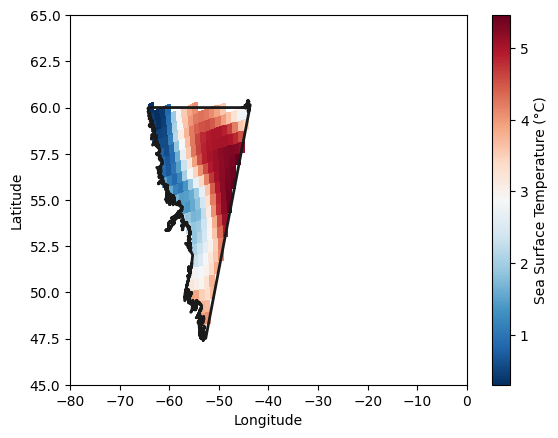

In [9]:
# Plotting Labrador Sea sub-domain:
plt.figure()
plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].where(mask).mean(dim='time_counter'), cmap='RdBu_r')
plt.plot(lon_poly, lat_poly, color='0.1', lw=2)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-80, 0])
plt.ylim([45, 65])


### **Calculating surface-forced water mass transformation**

**Now we have constructed our `NEMODataTree`, let's calculate the diapycnal surface-forced water mass trasformation from the surface density flux due to surface heat and freshwater fluxes.**

In [10]:
# Define specific heat capacity of sea water [J kg-1 K-1]:
cp0 = 3991.86795711963

# Add sea surface density fluxes due to heat and freshwater fluxes to T-grid of NEMODataTree:
nemo['/gridT']['f_hf'] = -(nemo['/gridT']['alpha'] / cp0) * nemo['/gridT']['hfds']
nemo['/gridT']['f_fw'] = nemo['/gridT']['beta'] * (nemo['/gridT']['sos_abs'] / (1 - nemo['/gridT']['sos_abs'])) * nemo['/gridT']['sowaflup']

In [11]:
# Define potential density bins [kg m-3]:
sigma0_bins = np.arange(22, 29.05, 0.05)
dsigma0 = 0.05

# Compute surface forced water mass transformation across each surface T-grid cell [m3 s-1].
nemo['gridT']['sfwmt'] = (1 / dsigma0) * (nemo['/gridT']['f_hf'] + nemo['/gridT']['f_fw']) * nemo.cell_area(grid='/gridT', dim='k')

# Compute total surface-force water mass transformation in discrete potential density coords:
sfwmt_sigma0_atl = nemo.binned_statistic(grid="/gridT",
                                         vars=["sigma0"],
                                         values="sfwmt",
                                         keep_dims=["time_counter"],
                                         bins=[sigma0_bins],
                                         statistic="nansum",
                                         mask=mask
                                         )

sfwmt_sigma0_atl

<xarray.DataArray 'sfwmt' (time_counter: 48, sigma0_bins: 140)> Size: 54kB
dask.array<reshape, shape=(48, 140), dtype=float64, chunksize=(48, 140), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-0...
  * sigma0_bins   (sigma0_bins) float64 1kB 22.02 22.08 22.12 ... 28.93 28.98

**Notice that the resulting DataArray includes a dask array, so we haven't actually computed the surface-forced water mass transformation yet. To do this, we need to call the ``.compute()`` method:**

In [12]:
# Compute diapycnal surface-forced water mass transformation in Sverdrups [1 Sv = 1E6 m3/s]:
sfwmt_sigma0_atl = (sfwmt_sigma0_atl / 1E6).compute()
sfwmt_sigma0_atl.name = 'sfwmt_sigma0_atl'

sfwmt_sigma0_atl

<xarray.DataArray 'sfwmt_sigma0_atl' (time_counter: 48, sigma0_bins: 140)> Size: 54kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(48, 140))
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-0...
  * sigma0_bins   (sigma0_bins) float64 1kB 22.02 22.08 22.12 ... 28.93 28.98

### **Visualising the time-mean surface-forced diapycnal overturning stream function**

**Finally, let's visualise the results by plotting the time-mean surface-forced overturning stream function in potential density-coordinates for the Atlantic Ocean:**

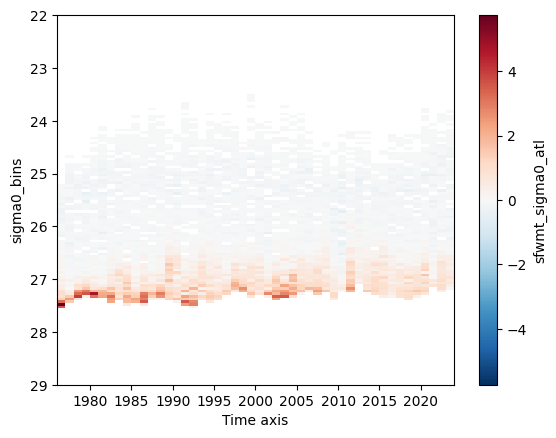

In [13]:
sfwmt_sigma0_atl.plot(y='sigma0_bins', yincrease=False)